In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) #ignore the warning to keep ipython clean

import numpy as np # linear algebra
import pandas as pd # train processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

C:\Users\Amin\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("../Data/train.csv", parse_dates=['timestamp'])
test = pd.read_csv("../Data/test.csv", parse_dates=['timestamp'])

y = train["price_doc"]
ylog = np.log(y)

#pred = pd.read_csv("mix_scale24_new_55_log.csv")
#pred = pd.read_csv("mix_scale24_new2_55.csv")
pred = pd.read_csv("../new4_scale16.csv")
ypred = pred["price_doc"]
ypred_log = np.log(ypred)

(13.5, 17)

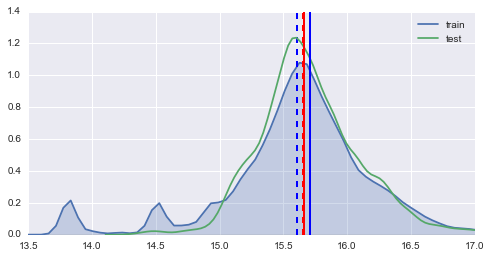

In [3]:
plt.figure(figsize=(8,4))
sns.kdeplot(ylog, shade=True, label="train")
plt.axvline(ylog.mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(ylog.median(), color='r', linestyle='dashed', linewidth=2)

sns.kdeplot(ypred_log, shade=False, label="test")
plt.axvline(ypred_log.mean(), color='b', linewidth=2)
plt.axvline(ypred_log.median(), color='r', linewidth=2)
plt.xlim([13.5,17])

In [4]:
train["year"] = train["timestamp"].dt.year
train["month"] = train["timestamp"].dt.month
train["time_month"] = (train['year'] - 2011) * 12 + train["month"]

test["year"] = test["timestamp"].dt.year
test["month"] = test["timestamp"].dt.month
test["time_month"] = (test['year'] - 2011) * 12 + test["month"]

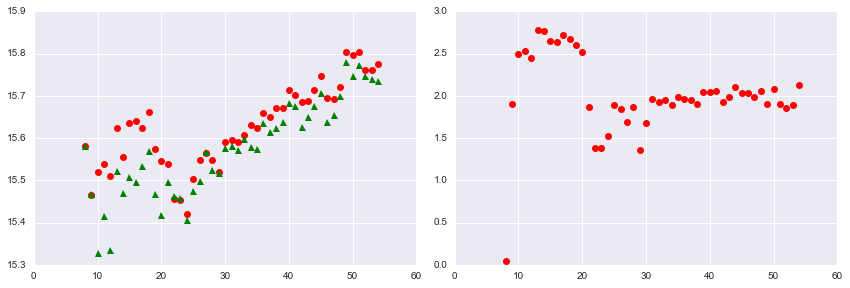

In [5]:
train['price'] = ylog
#train['time_month'] = train["time_month"].apply(str)
price_median = train.groupby('time_month')['price'].aggregate(np.median).reset_index()
price_mean = train.groupby('time_month')['price'].aggregate(np.mean).reset_index()
price_q1 = train.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,5)).reset_index()
price_q3 = train.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,95)).reset_index()

price_q1["delta"] = price_q3["price"] - price_q1["price"]


fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].plot(price_median["time_month"], price_median["price"], 'ro',
         price_mean["time_month"], price_mean["price"], 'g^')

axs[1].plot(price_q1["time_month"], price_q1["delta"], 'ro')

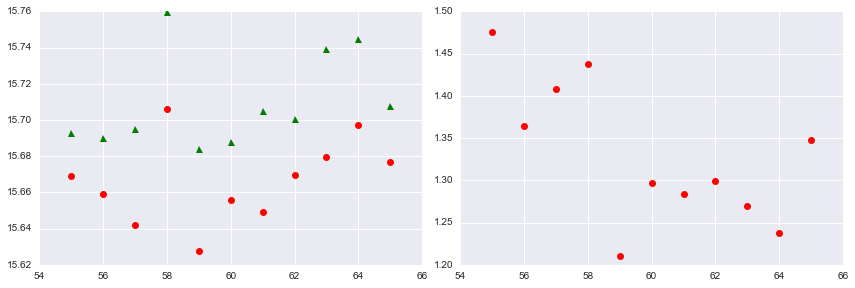

In [9]:
test['price'] = ypred_log
#test['time_month'] = train["time_month"].apply(str)
price_median = test.groupby('time_month')['price'].aggregate(np.median).reset_index()
price_mean = test.groupby('time_month')['price'].aggregate(np.mean).reset_index()
price_q1 = test.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,5)).reset_index()
price_q3 = test.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,95)).reset_index()

price_q1["delta"] = price_q3["price"] - price_q1["price"]


fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].plot(price_median["time_month"], price_median["price"], 'ro',
         price_mean["time_month"], price_mean["price"], 'g^')

axs[1].plot(price_q1["time_month"], price_q1["delta"], 'ro')

In [10]:
##test.loc[test.time_month == 55, "price"] = test.loc[test.time_month == 55, "price"] * 0.999
#test.loc[test.time_month == 56, "price"] = test.loc[test.time_month == 56, "price"] * 0.998
#test.loc[test.time_month == 57, "price"] = test.loc[test.time_month == 57, "price"] * 0.998
#test.loc[test.time_month == 58, "price"] = test.loc[test.time_month == 58, "price"] * 0.998
#test.loc[test.time_month == 59, "price"] = test.loc[test.time_month == 59, "price"] * 0.999
test.loc[test.time_month == 60, "price"] = test.loc[test.time_month == 60, "price"] * 0.998 #0.9975 # migth be down
##test.loc[test.time_month == 61, "price"] = test.loc[test.time_month == 61, "price"] * 0.999
##test.loc[test.time_month == 62, "price"] = test.loc[test.time_month == 62, "price"] * 0.999
#test.loc[test.time_month == 63, "price"] = test.loc[test.time_month == 63, "price"] * 1.002 #best top
#test.loc[test.time_month == 64, "price"] = test.loc[test.time_month == 64, "price"] * 1.002 #best top 
#test.loc[test.time_month == 65, "price"] = test.loc[test.time_month == 65, "price"] * 0.999

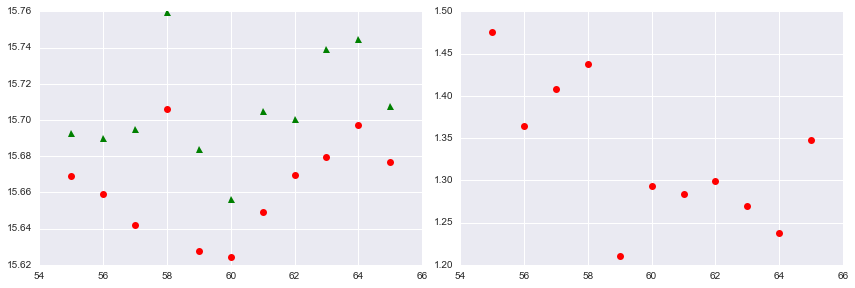

In [11]:
price_median = test.groupby('time_month')['price'].aggregate(np.median).reset_index()
price_mean = test.groupby('time_month')['price'].aggregate(np.mean).reset_index()
price_q1 = test.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,5)).reset_index()
price_q3 = test.groupby('time_month')['price'].aggregate(lambda x: np.percentile(x,95)).reset_index()

price_q1["delta"] = price_q3["price"] - price_q1["price"]


fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].plot(price_median["time_month"], price_median["price"], 'ro',
         price_mean["time_month"], price_mean["price"], 'g^')

axs[1].plot(price_q1["time_month"], price_q1["delta"], 'ro')

In [43]:
pwd

u'C:\\Users\\Amin\\Desktop\\Kaggle\\Backup'

In [44]:
#output = pred
#output["price_doc"] = np.exp(test.price)
#output.to_csv('../new4_scale16_time1.csv', index=False)

In [12]:
test.loc[test.state == 1.0, "price"] = test.loc[test.state == 1.0, "price"] * 1.001
test.loc[test.state == 2.0, "price"] = test.loc[test.state == 2.0, "price"] * 0.998
test.loc[test.state == 3.0, "price"] = test.loc[test.state == 3.0, "price"] * 1.002
test.loc[test.state == 4.0, "price"] = test.loc[test.state == 4.0, "price"] * 1.004
np.exp(test.price).head()

0    5.432552e+06
1    8.238588e+06
2    4.990296e+06
3    5.899602e+06
4    5.028089e+06
Name: price, dtype: float64

In [13]:
output = pred
output["price_doc"] = np.exp(test.price)
output.to_csv('../new4_scale16_state1_time1.csv', index=False)

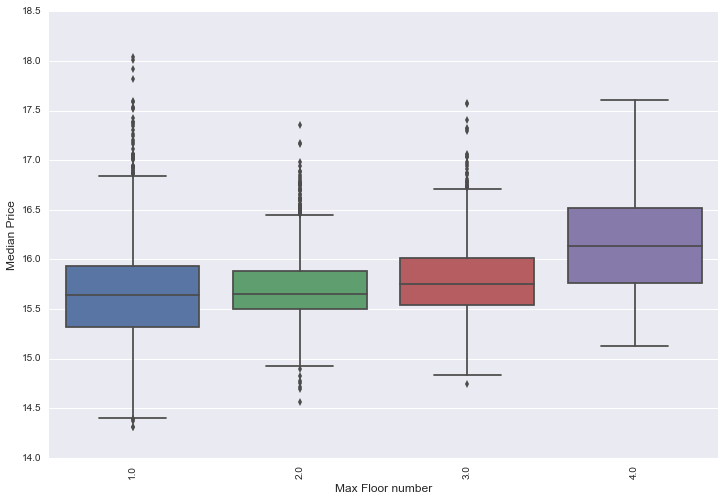

In [14]:
plt.figure(figsize=(12,8))
sns.boxplot(x="state", y="price", data=test)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

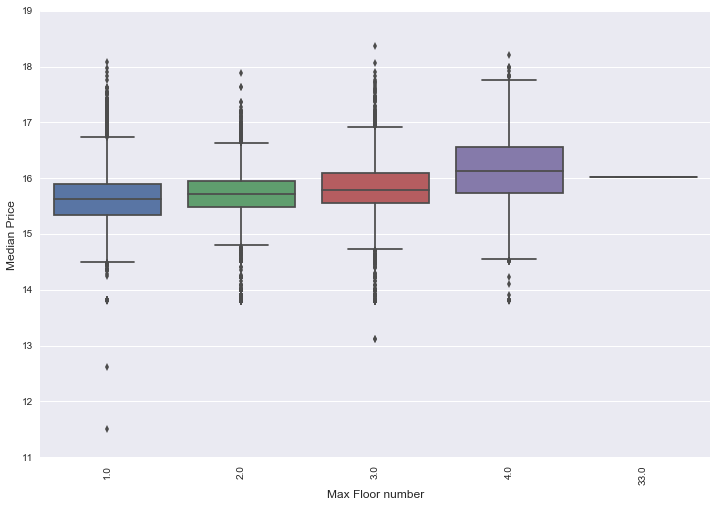

In [15]:
plt.figure(figsize=(12,8))
sns.boxplot(x="state", y="price", data=train)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()